In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-02-05 08:26:24,536 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
results_dir = '../../results/newLOO/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
pickle_files

array(['../../results/newLOO/A-crossval-swarm_12-005_2018-01-30_07-25-57.pickle',
       '../../results/newLOO/A-crossval-swarm_51-009_2018-02-04_13-46-32.pickle',
       '../../results/newLOO/A-crossval-swarm_52-001_2018-02-04_13-54-32.pickle',
       '../../results/newLOO/C-crossval-swarm_12-005_2018-01-30_17-00-54.pickle',
       '../../results/newLOO/C-crossval-swarm_51-009_2018-01-30_17-55-55.pickle',
       '../../results/newLOO/C-crossval-swarm_52-001_2018-01-30_17-59-15.pickle',
       '../../results/newLOO/D-crossval-swarm_12-005_2018-02-03_06-45-33.pickle',
       '../../results/newLOO/D-crossval-swarm_52-001_2018-02-03_06-46-52.pickle'], 
      dtype='<U71')

In [3]:
subjects = ['12-005', '51-009', '52-001']
models = ['A', 'C', 'D']
assert_params = {
    'amplitude': 2.0,
    'w_scale': 20,
    'w_rot': 0,
    'w_dice': 80
}

In [4]:
def calc_props(y_true):
    area = []
    orient = []
    major_minor = []
    for _, yt in y_true.iterrows():
        props = p2pspatial.imgproc.get_region_props(yt['image'], thresh=0.5)
        area.append(props.area ** 2)
        orient.append(np.rad2deg(props.orientation) ** 2)
        major_minor.append((props.major_axis_length / props.minor_axis_length) ** 2)
    return {'area': area, 'orientation': orient, 'major/minor': major_minor}

In [5]:
def calc_props_loss(ytyp, thresh):
    y_true, y_pred = ytyp
    yt_props = [p2pspatial.imgproc.get_region_props(yt['image'], thresh=0.5) for _, yt in y_true.iterrows()]
    yp_props = [p2pspatial.imgproc.get_region_props(yp['image'], thresh=thresh) for _, yp in y_pred.iterrows()]
    area = []
    orient = []
    major_minor = []
    for yt, yp in zip(yt_props, yp_props):
        if yp is None:
            continue
        # Calc area error in %:
        area.append((yt.area - yp.area) ** 2)
        # Calc orientation:
        err = np.rad2deg(np.abs(yt.orientation - yp.orientation))
        if err > 180:
            err = 360 - err
        orient.append(err ** 2)
        major_minor.append((yp.major_axis_length / yp.minor_axis_length - yt.major_axis_length / yp.minor_axis_length) ** 2)
    return {'area': area, 'orientation': orient, 'major/minor': major_minor}

In [18]:
loss = {a: {s: None for s in subjects} for a in models}
props = {s: None for s in subjects}
for file in pickle_files:
    y_test, y_pred, best_params, specifics = pickle.load(open(file, 'rb'))
    for key, value in six.iteritems(assert_params):
        assert np.isclose(specifics[key], value)
    n_folds = specifics['n_folds']
    assert len(y_pred) == n_folds
    assert len(y_test) == n_folds
    assert len(best_params) == n_folds
    model = specifics['modelname']
    subject = specifics['subject']
    if model not in models:
        print('Model %s found, skip.' % model)
        continue
    if subject not in subjects:
        print('Subject %s found, skip.' % subject)
        continue
    print('Processing Model %s, Subject %s' % (model, subject))
    
    loss[model][subject] = p2pu.parfor(calc_props_loss, zip(y_test, y_pred), func_args=[specifics['regressor'].img_thresh])
    props[subject] = p2pu.parfor(calc_props, y_test)

Processing Model A, Subject 12-005
Processing Model A, Subject 51-009
Processing Model A, Subject 52-001
Processing Model C, Subject 12-005
Processing Model C, Subject 51-009
Processing Model C, Subject 52-001
Processing Model D, Subject 12-005
Processing Model D, Subject 52-001


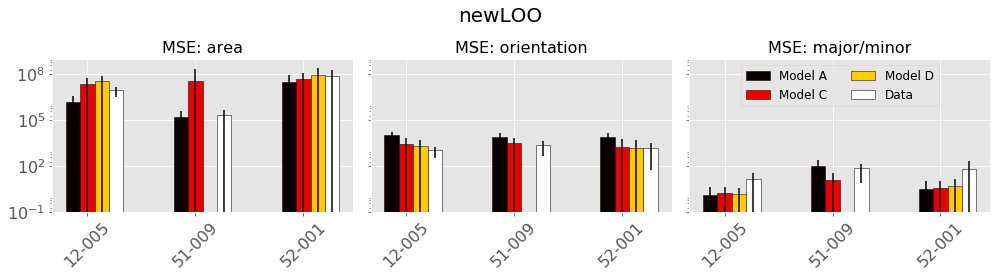

In [88]:
N = len(subjects)
width = 0.4 / N
ind = np.arange(N)

cols = ['area', 'orientation', 'major/minor']
fig, axes = plt.subplots(ncols=3, figsize=(14, 4), sharey=True)
cm = plt.get_cmap('hot')

for ax, col in zip(axes.ravel(), cols):
    rects = {}
    for m, model in enumerate(models):
        for s, subject in enumerate(subjects):
            if not loss[model][subject]:
                continue
            area = [p[col] for p in loss[model][subject]]
            area = [item for sublist in area for item in sublist]
            r = ax.bar(s + m * width, np.mean(area), width, yerr=np.std(area), 
                       color=cm(m / len(models)), edgecolor='k', 
                       label='Model %s' % model)
            rects[model] = r[0]
    for s, subject in enumerate(subjects):
        attr = [p[col] for p in props[subject]]
        attr = [item for sublist in attr for item in sublist]
        r = ax.bar(s + len(models) * width, np.mean(attr), width, yerr=np.std(attr),
                  color = 'w', edgecolor='k', label='Data')
    ax.set_xticks(ind + (len(rects) - 1) / 2 * width)
    ax.set_xticklabels(subjects, rotation=45, ha='center', fontsize=16)
    if col == 'major/minor':
        ax.legend([rects[m] for m in models if m in rects] + [r[0]],
                  ['Model ' + m for m in models if m in rects] + ['Data'], 
                  ncol=2, loc='upper center', fontsize=12)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_title('MSE: %s' % col, fontsize=16)
    ax.set_yscale('log')
#     allvals = [[item[col][0] for item in sublist] 
#                for sublist in filter(None, [l for _, l in loss['D'].items()])]
#     maxheight = max([item for sublist in allvals for item in sublist])
    ax.set_ylim(.1, 10 ** 9)
fig.suptitle(os.path.basename(os.path.dirname(results_dir)), fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
fig.savefig(os.path.join(results_dir, 'mse_props_loss.png'))

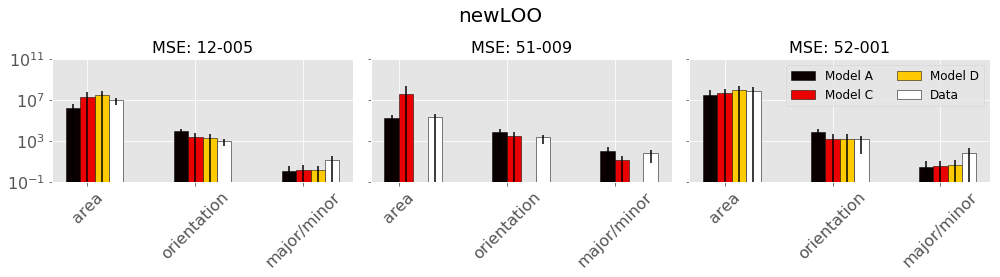

In [108]:
N = len(subjects)
width = 0.4 / N
ind = np.arange(N)

cols = ['area', 'orientation', 'major/minor']
fig, axes = plt.subplots(ncols=len(subjects), figsize=(14, 4), sharey=True)
cm = plt.get_cmap('hot')

for ax, subject in zip(axes.ravel(), subjects):
    rects = {}
    for m, model in enumerate(models):
        for c, col in enumerate(cols):
            if not loss[model][subject]:
                continue
            area = [p[col] for p in loss[model][subject]]
            area = [item for sublist in area for item in sublist]
            r = ax.bar(c + m * width, np.mean(area), width, yerr=np.std(area), 
                       color=cm(m / len(models)), edgecolor='k', 
                       label='Model %s' % model)
            rects[model] = r[0]
    for c, col in enumerate(cols):
        attr = [p[col] for p in props[subject]]
        attr = [item for sublist in attr for item in sublist]
        r = ax.bar(c + len(models) * width, np.mean(attr), width, yerr=np.std(attr),
                  color = 'w', edgecolor='k', label='Data')
    ax.set_xticks(ind + (len(rects) - 1) / 2 * width)
    ax.set_xticklabels(cols, rotation=45, ha='center', fontsize=16)
    if subject == '52-001':
        ax.legend([rects[m] for m in models if m in rects] + [r[0]],
                  ['Model ' + m for m in models if m in rects] + ['Data'], 
                  ncol=2, loc='upper right', fontsize=12)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_title('MSE: %s' % subject, fontsize=16)
    ax.set_yscale('log')
#     allvals = [[item[col][0] for item in sublist] 
#                for sublist in filter(None, [l for _, l in loss['D'].items()])]
#     maxheight = max([item for sublist in allvals for item in sublist])
    ax.set_ylim(0.1, 10 ** 11)
fig.suptitle(os.path.basename(os.path.dirname(results_dir)), fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
fig.savefig(os.path.join(results_dir, 'mse_props_loss.png'))